In [1]:
# 匯入套件
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler 
import numpy as np
import torch
import torch.nn as nn
import time

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")  

In [2]:
# 確認是否可以使用 GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
gpu_available = torch.cuda.is_available()

In [3]:
def stock(id):
    
    stockdf = f[f['name']==str(id)].dropna(axis=1).loc[:,'open':'rvi']
    #print(df)
    
    return stockdf

In [4]:
def split_data(stock, lookback, gapspace=0, test_set_size=120):
    
    # data_raw = stock.to_numpy() # convert to numpy array
    data_raw = stock
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback,:])
    
    data = np.array(data);

    # test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1-gapspace,:]
    y_train = data[:train_set_size,-1,3:4]
    x_test = data[train_set_size:,:-1-gapspace,:]
    y_test = data[train_set_size:,-1,3:4]
    
    print('x_train.shape = ',x_train.shape)
    print('y_train.shape = ',y_train.shape)
    print('x_test.shape = ',x_test.shape)
    print('y_test.shape = ',y_test.shape)
  
    x_train = torch.from_numpy(x_train).type(torch.Tensor)
    y_train= torch.from_numpy(y_train).type(torch.Tensor)
    x_test = torch.from_numpy(x_test).type(torch.Tensor)
    y_test= torch.from_numpy(y_test).type(torch.Tensor)
            
    x_train = x_train.to(device)
    y_train= y_train.to(device)
    x_test = x_test.to(device)
    y_test= y_test.to(device)
        
    return x_train, y_train, x_test, y_test

In [5]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        
        self.hidden_dim = hidden_dim 
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device).requires_grad_()
        
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        
        return out

In [6]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device).requires_grad_()
        
        out, (hn) = self.gru(x, (h0.detach()))
        out = self.fc(out[:, -1, :])
        
        return out

In [7]:
def model_train_predict(epochs=500, model_name = 'LSTM'):
      
    mseloss_train = np.zeros(epochs)
    mseloss_test = np.zeros(epochs)
    all_y_train_pred = []
    all_y_test_pred = []
    
    if model_name == 'LSTM':
        
        model = LSTM(input_dim=df.shape[1], hidden_dim=32, output_dim=1, num_layers=2)
        model = model.to(device)
        
        criterion = torch.nn.MSELoss(reduction='mean')
        optimiser = torch.optim.Adam(model.parameters(), lr=0.01)
     
    if model_name == 'GRU':
        
        model = GRU(input_dim=df.shape[1], hidden_dim=32, output_dim=1, num_layers=2)
        model = model.to(device)

        criterion = torch.nn.MSELoss(reduction='mean')
        optimiser = torch.optim.Adam(model.parameters(), lr=0.01)    

    for i in range(epochs):

        y_train_pred = model(x_train)
        loss = criterion(y_train_pred, y_train) 
        if (i+1)%10 == 0:
            print("Epoch ", i+1, "MSE: ", loss.item())
        mseloss_train[i] = loss.item()

        if gpu_available == False:  
            all_y_train_pred.append(scalertar.inverse_transform(y_train_pred.detach().numpy()))    
        else:
            all_y_train_pred.append(scalertar.inverse_transform(y_train_pred.cpu().detach().numpy()))                

        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

        y_test_pred = model(x_test)
        losst = criterion(y_test_pred, y_test) 
        mseloss_test[i] = losst.item()

        if gpu_available == False:
            all_y_test_pred.append(scalertar.inverse_transform(y_test_pred.detach().numpy()))
        else:
            all_y_test_pred.append(scalertar.inverse_transform(y_test_pred.cpu().detach().numpy())) 
    
    return all_y_train_pred, all_y_test_pred, mseloss_train, mseloss_test

In [8]:
# def LSTM_train_predict_tt(epochs=500):
      
#     mseloss_train = np.zeros(epochs)
#     mseloss_test = np.zeros(epochs)
#     all_y_train_pred = []
#     all_y_test_pred = []

#     for i in range(epochs):
        
#         y_train_pred = modelL(x_train)
#         loss = criterion(y_train_pred, y_train) 
#         if (i+1)%10 == 0:
#             print("Epoch ", i+1, "MSE: ", loss.item())
#         mseloss_train[i] = loss.item()
        
#         if gpu_available == False:  
#             all_y_train_pred.append(scalertar.inverse_transform(y_train_pred.detach().numpy()))    
#         else:
#             all_y_train_pred.append(scalertar.inverse_transform(y_train_pred.cpu().detach().numpy()))                
                         
#         optimiserL.zero_grad()
#         loss.backward()
#         optimiserL.step()
        
#         y_test_pred = modelL(x_test)
#         losst = criterion(y_test_pred, y_test) 
#         mseloss_test[i] = losst.item()
        
#         if gpu_available == False:
#             all_y_test_pred.append(scalertar.inverse_transform(y_test_pred.detach().numpy()))
#         else:
#             all_y_test_pred.append(scalertar.inverse_transform(y_test_pred.cpu().detach().numpy())) 
    
#     return all_y_train_pred, all_y_test_pred, mseloss_train, mseloss_test

In [9]:
# def GRU_train_predict_tt(epochs=500):
      
#     mseloss_train = np.zeros(epochs)
#     mseloss_test = np.zeros(epochs)
#     all_y_train_pred = []
#     all_y_test_pred = []

#     for i in range(epochs):
        
#         y_train_pred = modelG(x_train)
#         loss = criterion(y_train_pred, y_train) 
#         if (i+1)%10 == 0:
#             print("Epoch ", i+1, "MSE: ", loss.item())
#         mseloss_train[i] = loss.item()
        
#         if gpu_available == False:  
#             all_y_train_pred.append(scalertar.inverse_transform(y_train_pred.detach().numpy()))    
#         else:
#             all_y_train_pred.append(scalertar.inverse_transform(y_train_pred.cpu().detach().numpy()))                 
                         
#         optimiserG.zero_grad()
#         loss.backward()
#         optimiserG.step()

#         y_test_pred = modelG(x_test)
#         losst = criterion(y_test_pred, y_test) 
#         mseloss_test[i] = losst.item()
        
#         if gpu_available == False:
#             all_y_test_pred.append(scalertar.inverse_transform(y_test_pred.detach().numpy()))
#         else:
#             all_y_test_pred.append(scalertar.inverse_transform(y_test_pred.cpu().detach().numpy())) 
    
#     return all_y_train_pred, all_y_test_pred, mseloss_train, mseloss_test

In [10]:
def chart(data1, label_name1, data2, label_name2):
    
    plt.figure(figsize=(16, 12))
    ax = sns.lineplot(data=data1, label=label_name1, color='royalblue')
    ax = sns.lineplot(data=data2, label=label_name2, color='tomato')
    ax.set_title('Stock price', size = 14, fontweight='bold')
    ax.set_xlabel("Days", size = 14)
    ax.set_ylabel("Stock Price (TWD)", size = 14)
    ax.set_xticklabels('', size=10)
    plt.show()


# START

In [11]:
# 檔案讀取大表
f = pd.read_csv('clean_long_dataset.csv')

In [12]:
df=stock('2014.TW')

In [13]:
df.shape

(2436, 189)

In [14]:
scalertar = MinMaxScaler()
scalertar_data = scalertar.fit_transform(df.iloc[:,3].values.reshape(-1, 1))

In [15]:
scaler = MinMaxScaler()
scaler_data = scaler.fit_transform(df.values)

In [16]:
# modelL = LSTM(input_dim=df.shape[1], hidden_dim=32, output_dim=1, num_layers=2)
# modelG = GRU(input_dim=df.shape[1], hidden_dim=32, output_dim=1, num_layers=2)

# modelL = modelL.to(device)
# modelG = modelG.to(device)

# criterion = torch.nn.MSELoss(reduction='mean')
# optimiserL = torch.optim.Adam(modelL.parameters(), lr=0.01)
# optimiserG = torch.optim.Adam(modelG.parameters(), lr=0.01)

### LSTM

In [17]:
x_train, y_train, x_test, y_test = split_data(scaler_data, lookback=10, gapspace=0, test_set_size=120)

x_train.shape =  (2306, 9, 189)
y_train.shape =  (2306, 1)
x_test.shape =  (120, 9, 189)
y_test.shape =  (120, 1)


In [18]:
all_y_train_pred, all_y_test_pred, mseloss_train, mseloss_test = model_train_predict(epochs=500, model_name = 'LSTM')

Epoch  10 MSE:  0.002444776240736246
Epoch  20 MSE:  0.0017144557787105441
Epoch  30 MSE:  0.0014947181334719062
Epoch  40 MSE:  0.0012284198310226202
Epoch  50 MSE:  0.0007236970704980195
Epoch  60 MSE:  0.00023273794795386493
Epoch  70 MSE:  8.211434033000842e-05
Epoch  80 MSE:  6.620021304115653e-05
Epoch  90 MSE:  4.9313344788970426e-05
Epoch  100 MSE:  3.859688513330184e-05
Epoch  110 MSE:  3.255873525631614e-05
Epoch  120 MSE:  2.9810982596245594e-05
Epoch  130 MSE:  2.776016845018603e-05
Epoch  140 MSE:  2.6445373805472627e-05
Epoch  150 MSE:  2.5333025405416265e-05
Epoch  160 MSE:  2.4415374355157837e-05
Epoch  170 MSE:  2.361370025028009e-05
Epoch  180 MSE:  2.290898555656895e-05
Epoch  190 MSE:  2.2283100406639278e-05
Epoch  200 MSE:  2.1721240045735613e-05
Epoch  210 MSE:  2.1213201762293465e-05
Epoch  220 MSE:  2.075074917229358e-05
Epoch  230 MSE:  2.0327632228145376e-05
Epoch  240 MSE:  1.9938717741752043e-05
Epoch  250 MSE:  1.9579721993068233e-05
Epoch  260 MSE:  1.9247

In [19]:
# invert data

if gpu_available == False:

    y_train = scalertar.inverse_transform(y_train.detach().numpy())
    y_test = scalertar.inverse_transform(y_test.detach().numpy())
    
else:

    y_train = scalertar.inverse_transform(y_train.cpu().detach().numpy())
    y_test = scalertar.inverse_transform(y_test.cpu().detach().numpy())

In [20]:
import math, time
from sklearn.metrics import mean_squared_error, r2_score

allTrainRMSE = []
allTestRMSE = []

for i in range(len(all_y_train_pred)):
    allTrainRMSE.append(math.sqrt(mean_squared_error(y_train[:,0], all_y_train_pred[i][:,0])))
    allTestRMSE.append(math.sqrt(mean_squared_error(y_test[:,0], all_y_test_pred[i][:,0])))

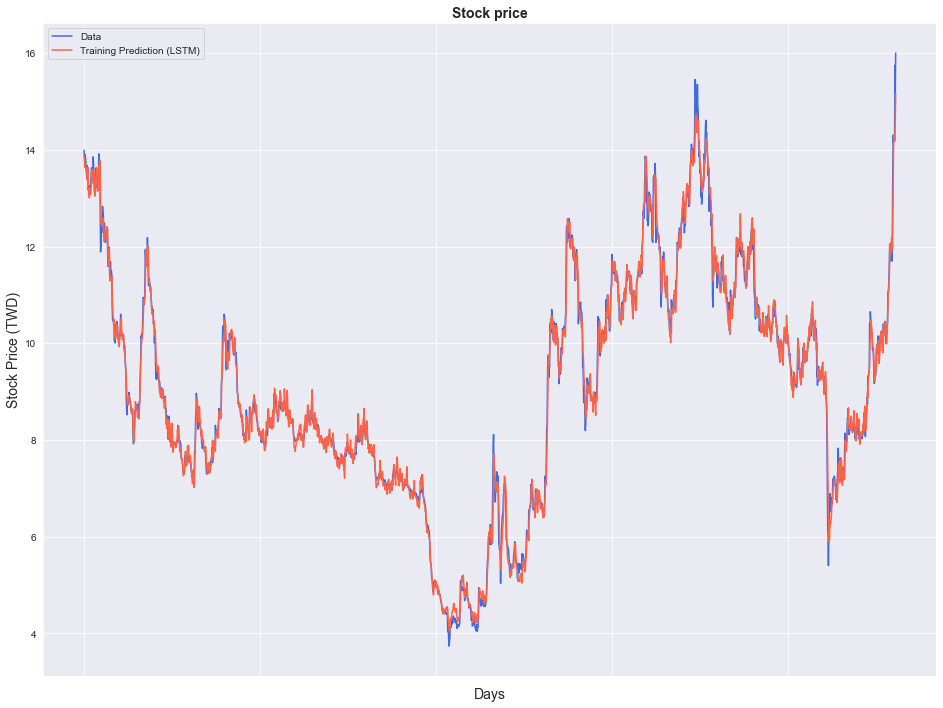

In [21]:
chart(y_train.ravel(), "Data",all_y_train_pred[-1].ravel(), "Training Prediction (LSTM)")

In [22]:
# plt.figure(figsize=(16, 12))

# ax = sns.lineplot(data=y_train.ravel(), label="Data", color='royalblue')
# ax = sns.lineplot(data=all_y_train_pred[-1].ravel(), label="Training Prediction (LSTM)", color='tomato')
# ax.set_title('Stock price', size = 14, fontweight='bold')
# ax.set_xlabel("Days", size = 14)
# ax.set_ylabel("Stock Price (TWD)", size = 14)
# ax.set_xticklabels('', size=10)

# plt.show()

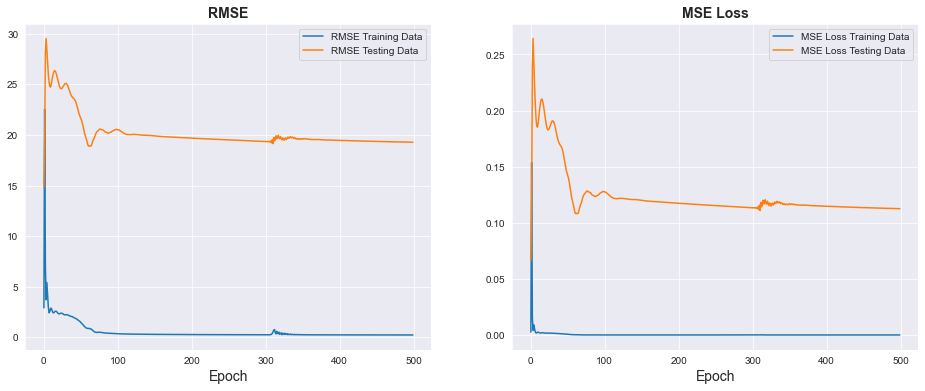

In [23]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(data=allTrainRMSE, label="RMSE Training Data")
ax = sns.lineplot(data=allTestRMSE, label="RMSE Testing Data")
ax.set_xlabel("Epoch", size = 14)
ax.set_title("RMSE", size = 14, fontweight='bold')

plt.subplot(1, 2, 2)
ax = sns.lineplot(data=mseloss_train, label="MSE Loss Training Data")
ax = sns.lineplot(data=mseloss_test, label="MSE Loss Testing Data")
ax.set_xlabel("Epoch", size = 14)
ax.set_title("MSE Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)

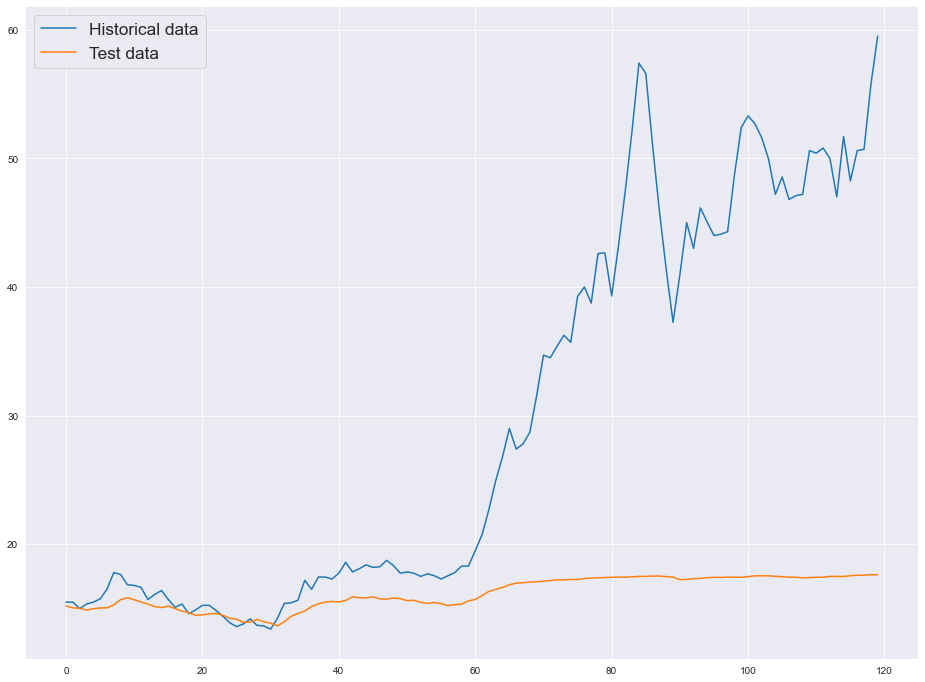

In [24]:
plt.figure(figsize=(16, 12))

plt.plot(y_test, label='Historical data')
plt.plot(all_y_test_pred[-1], label='Test data')
plt.legend(fontsize='xx-large', loc='upper left')

plt.show()

In [25]:
# calculate root mean squared error
trainRMSE = math.sqrt(mean_squared_error(y_train[:,0], all_y_train_pred[i][:,0]))
testRMSE = math.sqrt(mean_squared_error(y_test[:,0], all_y_test_pred[i][:,0]))


trainR2 = r2_score(y_train[:,0], all_y_train_pred[-1][:,0])
testR2 = r2_score(y_test[:,0], all_y_test_pred[-1][:,0])


trainAdjR2 = 1-(1-trainR2)*((len(x_train)-1)/(len(x_train)-x_train.shape[2]-1))
testAdjR2 = 1-(1-testR2)*((len(x_test)-1)/(len(x_test)-x_test.shape[2]-1))


ldf = pd.DataFrame({'RMSE': [trainRMSE, testRMSE],
                    'R2 Score': [trainR2, testR2],
                    'Adj R2 Score': [trainAdjR2, testAdjR2]},
                   index=['Train', 'Test'])

ldf

# lstm.append(trainScore)
# lstm.append(testScore)
# lstm.append(training_time)

,RMSE,R2 Score,Adj R2 Score
Train,0.228053,0.990692,0.989861
Test,19.281591,-0.667249,3.834324


In [26]:
lstmdata = all_y_test_pred[-1]

### GRU

In [27]:
x_train, y_train, x_test, y_test = split_data(scaler_data, lookback=10, gapspace=0, test_set_size=120)

x_train.shape =  (2306, 9, 189)
y_train.shape =  (2306, 1)
x_test.shape =  (120, 9, 189)
y_test.shape =  (120, 1)


In [28]:
all_y_train_pred, all_y_test_pred, mseloss_train, mseloss_test = model_train_predict(epochs=500, model_name = 'GRU')

Epoch  10 MSE:  0.0019916866440325975
Epoch  20 MSE:  0.010550119914114475
Epoch  30 MSE:  0.0019864311907440424
Epoch  40 MSE:  0.0015295966295525432
Epoch  50 MSE:  0.0016421796754002571
Epoch  60 MSE:  0.0013836411526426673
Epoch  70 MSE:  0.0011239700252190232
Epoch  80 MSE:  0.000945973617490381
Epoch  90 MSE:  0.0007025939412415028
Epoch  100 MSE:  0.0004521432565525174
Epoch  110 MSE:  0.0002551961224526167
Epoch  120 MSE:  0.00013286271132528782
Epoch  130 MSE:  8.76762205734849e-05
Epoch  140 MSE:  7.190199539763853e-05
Epoch  150 MSE:  6.388449401129037e-05
Epoch  160 MSE:  5.8856156101683155e-05
Epoch  170 MSE:  5.533453804673627e-05
Epoch  180 MSE:  5.234842683421448e-05
Epoch  190 MSE:  4.9976646550931036e-05
Epoch  200 MSE:  4.797419023816474e-05
Epoch  210 MSE:  4.623653876478784e-05
Epoch  220 MSE:  4.471650026971474e-05
Epoch  230 MSE:  4.337033533374779e-05
Epoch  240 MSE:  4.216784509480931e-05
Epoch  250 MSE:  4.10835345974192e-05
Epoch  260 MSE:  4.0097809687722474

In [29]:
# invert data

if gpu_available == False:

    y_train = scalertar.inverse_transform(y_train.detach().numpy())
    y_test = scalertar.inverse_transform(y_test.detach().numpy())
    
else:

    y_train = scalertar.inverse_transform(y_train.cpu().detach().numpy())
    y_test = scalertar.inverse_transform(y_test.cpu().detach().numpy())

In [30]:
import math, time
from sklearn.metrics import mean_squared_error, r2_score

allTrainRMSE = []
allTestRMSE = []

for i in range(len(all_y_train_pred)):
    allTrainRMSE.append(math.sqrt(mean_squared_error(y_train[:,0], all_y_train_pred[i][:,0])))
    allTestRMSE.append(math.sqrt(mean_squared_error(y_test[:,0], all_y_test_pred[i][:,0])))

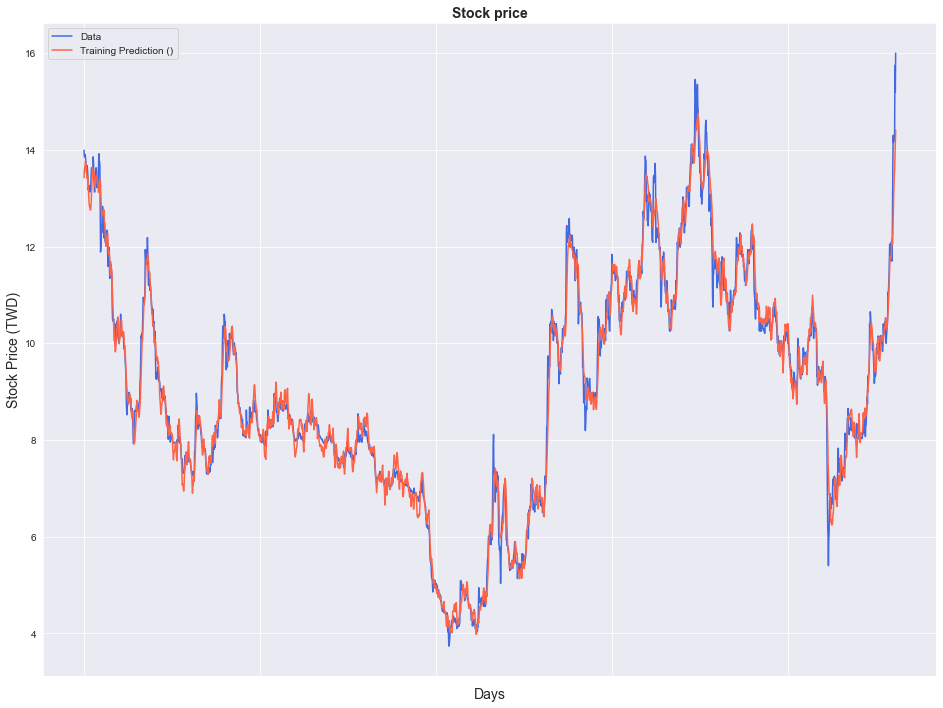

In [31]:
plt.figure(figsize=(16, 12))

ax = sns.lineplot(data=y_train.ravel(), label="Data", color='royalblue')
ax = sns.lineplot(data=all_y_train_pred[-1].ravel(), label="Training Prediction ()", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Stock Price (TWD)", size = 14)
ax.set_xticklabels('', size=10)

plt.show()

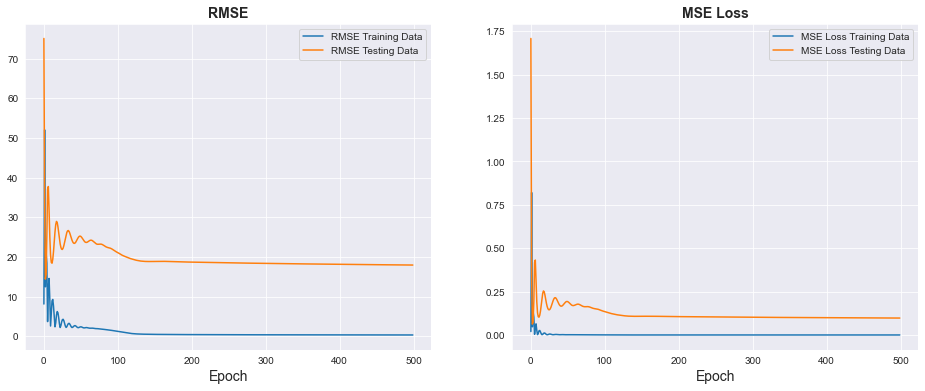

In [32]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(data=allTrainRMSE, label="RMSE Training Data")
ax = sns.lineplot(data=allTestRMSE, label="RMSE Testing Data")
ax.set_xlabel("Epoch", size = 14)
ax.set_title("RMSE", size = 14, fontweight='bold')

plt.subplot(1, 2, 2)
ax = sns.lineplot(data=mseloss_train, label="MSE Loss Training Data")
ax = sns.lineplot(data=mseloss_test, label="MSE Loss Testing Data")
ax.set_xlabel("Epoch", size = 14)
ax.set_title("MSE Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)

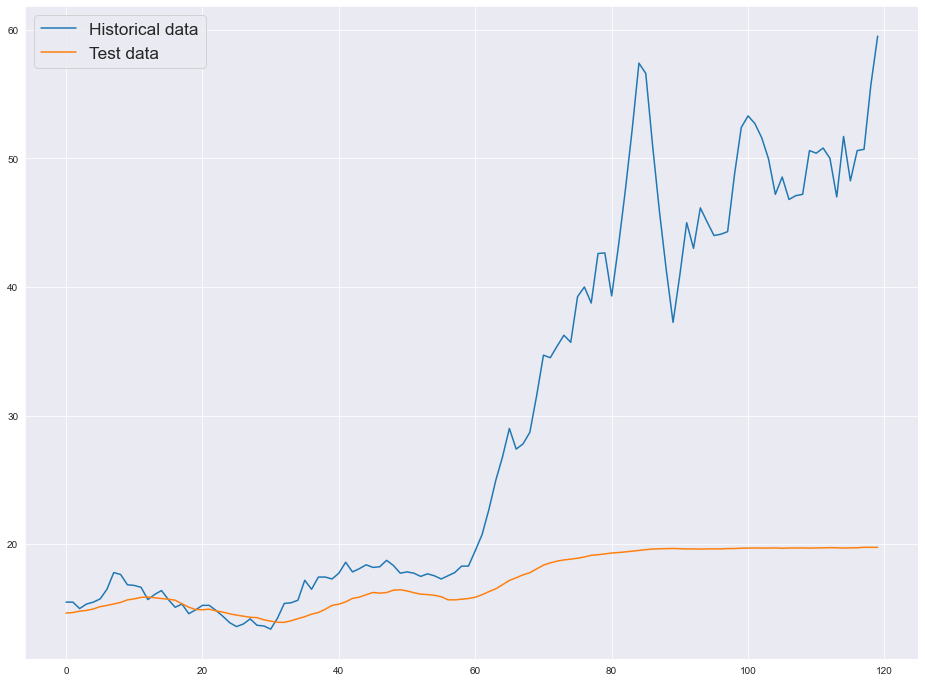

In [33]:
plt.figure(figsize=(16, 12))

plt.plot(y_test, label='Historical data')
plt.plot(all_y_test_pred[-1], label='Test data')
plt.legend(fontsize='xx-large', loc='upper left')

plt.show()

In [34]:
# calculate root mean squared error
trainRMSE = math.sqrt(mean_squared_error(y_train[:,0], all_y_train_pred[i][:,0]))
testRMSE = math.sqrt(mean_squared_error(y_test[:,0], all_y_test_pred[i][:,0]))


trainR2 = r2_score(y_train[:,0], all_y_train_pred[-1][:,0])
testR2 = r2_score(y_test[:,0], all_y_test_pred[-1][:,0])


trainAdjR2 = 1-(1-trainR2)*((len(x_train)-1)/(len(x_train)-x_train.shape[2]-1))
testAdjR2 = 1-(1-testR2)*((len(x_test)-1)/(len(x_test)-x_test.shape[2]-1))


gdf = pd.DataFrame({'RMSE': [trainRMSE, testRMSE],
                    'R2 Score': [trainR2, testR2],
                    'Adj R2 Score': [trainAdjR2, testAdjR2]},
                   index=['Train', 'Test'])

gdf

# lstm.append(trainScore)
# lstm.append(testScore)
# lstm.append(training_time)

,RMSE,R2 Score,Adj R2 Score
Train,0.304510,0.983405,0.981923
Test,17.950113,-0.444938,3.456394


In [35]:
ldf

,RMSE,R2 Score,Adj R2 Score
Train,0.228053,0.990692,0.989861
Test,19.281591,-0.667249,3.834324


In [36]:
grudata = all_y_test_pred[-1]

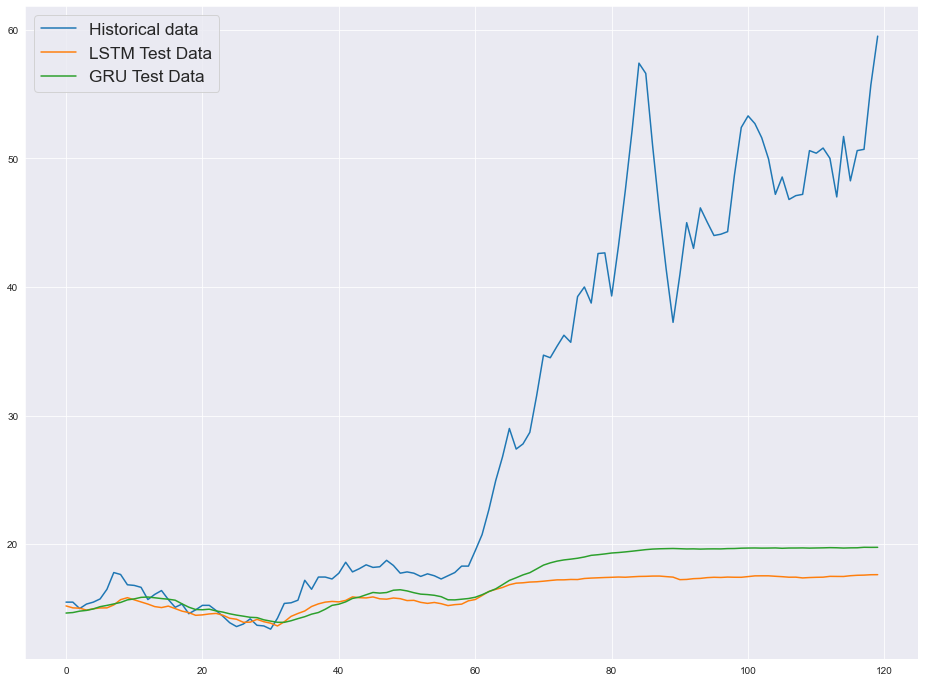

In [37]:
plt.figure(figsize=(16, 12))

plt.plot(y_test, label='Historical data')
plt.plot(lstmdata, label='LSTM Test Data')
plt.plot(grudata, label='GRU Test Data')
plt.legend(fontsize='xx-large', loc='upper left')

plt.show()